

EfficientNetB0 + vit_base_patch16_224  → Attention_based fusion → Dense → Output



In [ ]:
pip install tensorflow

In [ ]:
# Import necessary libraries
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# DataSet


dataset_path = '/content/drive/MyDrive/dataset/AMDNet23_Dataset'
IMG_SIZE = 224  # Image size for input (224x224 for most models)


# Get class names from the 'train' split folder
train_split_path = os.path.join(dataset_path, 'train')

if not os.path.exists(train_split_path):
    raise FileNotFoundError(f"Training split folder not found at '{train_split_path}'. ")


class_names = sorted([d for d in os.listdir(train_split_path) if os.path.isdir(os.path.join(train_split_path, d))])
if not class_names:
    raise ValueError(f"No class folders found inside '{train_split_path}'. "
                     f"Expected structure: {train_split_path}/class_name/images. ")

print(f"Detected Class names: {class_names}")


Detected Class names: ['amd', 'cataract', 'diabetes', 'normal']


In [ ]:
#Data Distribution

image_counts = {class_name: 0 for class_name in class_names}
for split_name in ['train', 'valid']:
    split_folder = os.path.join(dataset_path, split_name)
    if os.path.isdir(split_folder):
        print(f"--- Processing split: {split_name} ---")
        for class_name in class_names:
            class_folder = os.path.join(split_folder, class_name)
            if os.path.isdir(class_folder):
                current_count = len([f for f in os.listdir(class_folder) if os.path.isfile(os.path.join(class_folder, f))])
                image_counts[class_name] += current_count
                print(f"  Class '{class_name}': {current_count} images in {split_name}")
            else:
                print(f"  Warning: Class folder '{class_folder}' not found in split '{split_name}'.")
    else:
        print(f"Warning: Split folder '{split_folder}' not found. Skipping.")
print("Total Image distribution across all classes:", image_counts)



--- Processing split: train ---
  Class 'amd': 394 images in train
  Class 'cataract': 400 images in train
  Class 'diabetes': 400 images in train
  Class 'normal': 400 images in train
--- Processing split: valid ---
  Class 'amd': 100 images in valid
  Class 'cataract': 100 images in valid
  Class 'diabetes': 100 images in valid
  Class 'normal': 100 images in valid
Total Image distribution across all classes: {'amd': 494, 'cataract': 500, 'diabetes': 500, 'normal': 500}


In [ ]:
# Data Preprocessing --> (CLAHE + Gamma Correction + Resize)

def preprocess_image(image_path):
    image = cv2.imread(image_path)  # Read image
    if image is None:
        print(f"Warning: Could not read image {image_path}")
        return None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB from BGR, cause most deep learning frameworks expect RGB order.

    # Apply CLAHE
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    image = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

    # Apply Gamma Correction
    gamma = 1.5
    image = np.array(image / 255.0, dtype=np.float32)
    image = np.power(image, gamma)

    # Resize the image
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

    return image

In [ ]:
#load images

def load_images_from_split(base_dataset_path, split_name, class_names_list):
    images = []
    labels = []

    split_folder = os.path.join(base_dataset_path, split_name)
    if not os.path.isdir(split_folder):
        raise ValueError(f"Split folder not found: {split_folder}")

    for class_name in class_names_list:
        class_folder = os.path.join(split_folder, class_name)
        if not os.path.isdir(class_folder):
            print(f"Skipping missing class folder: {class_folder}")
            continue

        for filename in os.listdir(class_folder):
            image_path = os.path.join(class_folder, filename)

            if os.path.isfile(image_path):
                image = cv2.imread(image_path)
                if image is None:
                    print(f"Warning: Could not read image {image_path}")
                    continue

                # BGR → RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Resize
                image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

                # Normalize (NOT enhancement)
                image = image.astype(np.float32) / 255.0

                images.append(image)
                labels.append(class_name)

    return np.array(images), np.array(labels)


X_train_all, y_train_all = load_images_from_split(
    dataset_path,
    'train',
    class_names
)

X_test, y_test = load_images_from_split(
    dataset_path,
    'valid',
    class_names
)



In [ ]:
# Data Augmentation setup

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# dataset split

X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.3, stratify=y_train_all, random_state=42)


print(f"Training images: {len(X_train)}, Validation images: {len(X_val)}, Test images: {len(X_test)}")

Training images: 1115, Validation images: 479, Test images: 400


In [ ]:
def cross_attention_fusion(cnn_features, vit_features, num_heads=8, key_dim=512):
    cnn_seq = layers.Reshape((1, -1))(cnn_features)
    vit_seq = layers.Reshape((1, -1))(vit_features)

    # 1. ViT queries the CNN (looking for local details)
    # Query: ViT, Key/Value: CNN
    vit_to_cnn = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=key_dim, name="attn_vit_to_cnn"
    )(query=vit_seq, value=cnn_seq, key=cnn_seq)

    # 2. CNN queries the ViT (looking for global context)
    # Query: CNN, Key/Value: ViT
    cnn_to_vit = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=key_dim, name="attn_cnn_to_vit"
    )(query=cnn_seq, value=vit_seq, key=vit_seq)

    # Residual Connections & Normalization
    fused_vit = layers.Add()([vit_seq, vit_to_cnn])
    fused_vit = layers.LayerNormalization()(fused_vit)

    fused_cnn = layers.Add()([cnn_seq, cnn_to_vit])
    fused_cnn = layers.LayerNormalization()(fused_cnn)

    # Combine the reinforced features
    combined = layers.Concatenate()([fused_vit, fused_cnn])
    return layers.Flatten()(combined)

In [ ]:
!pip install -U keras-hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.0 MB/s eta 0:00:00
  Attempting uninstall: keras-hub
    Found existing installation: keras-hub 0.21.1
    Uninstalling keras-hub-0.21.1:
      Successfully uninstalled keras-hub-0.21.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-nlp 0.21.1 requires keras-hub==0.21.1, but you have keras-hub 0.25.1 which is incompatible.


In [ ]:
# Model
from transformers import TFViTModel
import keras_hub

def cnn_feature_extractor(input_shape=(IMG_SIZE, IMG_SIZE, 3)):

    base_model = EfficientNetB0(
        include_top=False,
        input_shape=input_shape,
        weights="imagenet"
    )
    base_model.trainable = False

    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    return models.Model(inputs, x, name="cnn_feature_extractor")



def vit_b16_feature_extractor(input_shape=(224, 224, 3)):

    backbone = keras_hub.models.ViTBackbone.from_preset(
        "vit_base_patch16_224_imagenet",
        load_weights=True
    )
    backbone.trainable = False

    inputs = layers.Input(shape=input_shape)

    # Extract features
    outputs = backbone(inputs)

    # ViTBackbone typically returns a dictionary or a specific tensor
    # We want the pooled output (index [0] or the 'pooled_output' key)
    # For ViT, the first token is usually the classification token
    if isinstance(outputs, dict):
        x = outputs["pooled_output"]
    else:
        x = outputs[:, 0, :] # Grab CLS token if it returns a 3D tensor

    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    return models.Model(inputs, x, name="vit_b16_extractor")

cnn_encoder = cnn_feature_extractor()
vit_encoder = vit_b16_feature_extractor()

def build_intermediate_fusion_model(input_shape=(IMG_SIZE, IMG_SIZE, 3)):

    inputs = layers.Input(shape=input_shape)

    cnn_features = cnn_encoder(inputs)
    vit_features = vit_encoder(inputs)

    fused = cross_attention_fusion(cnn_features, vit_features)

    # Final Classification
    x = layers.Dense(512, activation='relu', name="fusion_dense")(fused)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(
        len(class_names),
        activation='softmax',
        name="output_layer"
    )(x)

    return models.Model(inputs=inputs, outputs=outputs, name="cnn_vit_attention_fusion")

hybrid_model = build_intermediate_fusion_model()

hybrid_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

hybrid_model.summary()


Model: "cnn_vit_attention_fusion"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vit_b16_extractor   │ (None, 512)       │ 86,192,384 │ input_layer_19[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_feature_extrac… │ (None, 512)       │  4,705,443 │ input_layer_19[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 512)    │          0 │ vit_b16_extracto… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 512)    │          0 │ cnn_feature_extr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attn_vit_to_cnn     │ (None, 1, 512)    │  8,401,408 │ reshape_1[0][0],  │
│ (MultiHeadAttentio… │                   │            │ reshape_2[0][0],  │
│                     │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attn_cnn_to_vit     │ (None, 1, 512)    │  8,401,408 │ reshape_2[0][0],  │
│ (MultiHeadAttentio… │                   │            │ reshape_1[0][0],  │
│                     │                   │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 512)    │          0 │ reshape_2[0][0],  │
│                     │                   │            │ attn_vit_to_cnn[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1, 512)    │          0 │ reshape_1[0][0],  │
│                     │                   │            │ attn_cnn_to_vit[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 1, 512)    │      1,024 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 512)    │      1,024 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1, 1024)   │          0 │ layer_normalizat… │
│ (Concatenate)       │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1024)      │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_dense        │ (None, 512)       │    524,800 │ flatten[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_48          │ (None, 512)       │          0 │ fusion_dense[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 4)         │      2,052 │ dropout_48[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 108,229,543 (412.86 MB)

 Trainable params: 18,381,316 (70.12 MB)

 Non-trainable params: 89,848,227 (342.74 MB)

Mapping labels: {'amd': 0, 'cataract': 1, 'diabetes': 2, 'normal': 3}
X_train shape: (1115, 224, 224, 3), y_train shape: (1115,)
Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.3765 - loss: 2.8375 - val_accuracy: 0.7077 - val_loss: 0.7192
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 618ms/step - accuracy: 0.5700 - loss: 0.8936 - val_accuracy: 0.7161 - val_loss: 0.6227
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 632ms/step - accuracy: 0.6586 - loss: 0.7280 - val_accuracy: 0.7620 - val_loss: 0.5393
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 618ms/step - accuracy: 0.7656 - loss: 0.5743 - val_accuracy: 0.8413 - val_loss: 0.4523
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 613ms/step - accuracy: 0.8335 - loss: 0.4505 - val_accuracy: 0.8685 - val_loss: 0.3901
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 618ms/step - accuracy: 0.8559 - loss: 0.4103 - val_accuracy: 0.8727 - val_loss: 0.3836
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 610ms/step - accuracy: 0.8325 - loss: 0.4393 - val_accura

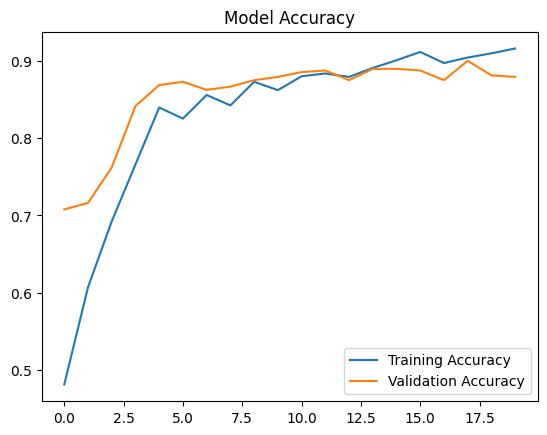

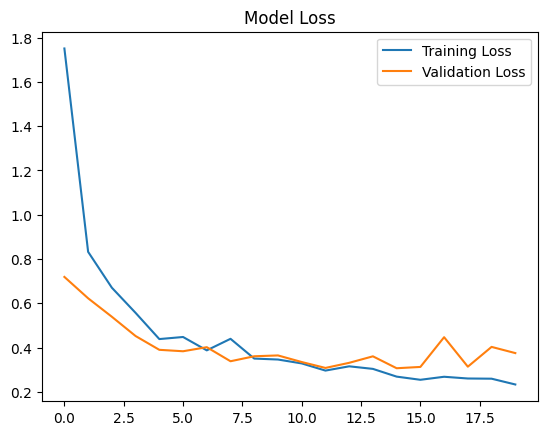

In [ ]:
#Training Set Up

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)



batch_size = 32

label_map = {name: i for i, name in enumerate(class_names)}
print(f"Mapping labels: {label_map}")

try:
    y_train = np.array(y_train).astype('int32')
    y_val = np.array(y_val).astype('int32')
    y_test = np.array(y_test).astype('int32')
except ValueError:
    # If they were strings, then use the map
    y_train = np.array([label_map[l] for l in y_train]).astype('int32')
    y_val = np.array([label_map[l] for l in y_val]).astype('int32')
    y_test = np.array([label_map[l] for l in y_test]).astype('int32')

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(len(X_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

history = hybrid_model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[early_stopping]
)


# accuracy and loss curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step
--- Classification Report ---
              precision    recall  f1-score   support

         amd       0.95      0.86      0.90       100
    cataract       0.99      0.99      0.99       100
    diabetes       0.84      0.85      0.85       100
      normal       0.88      0.95      0.91       100

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400



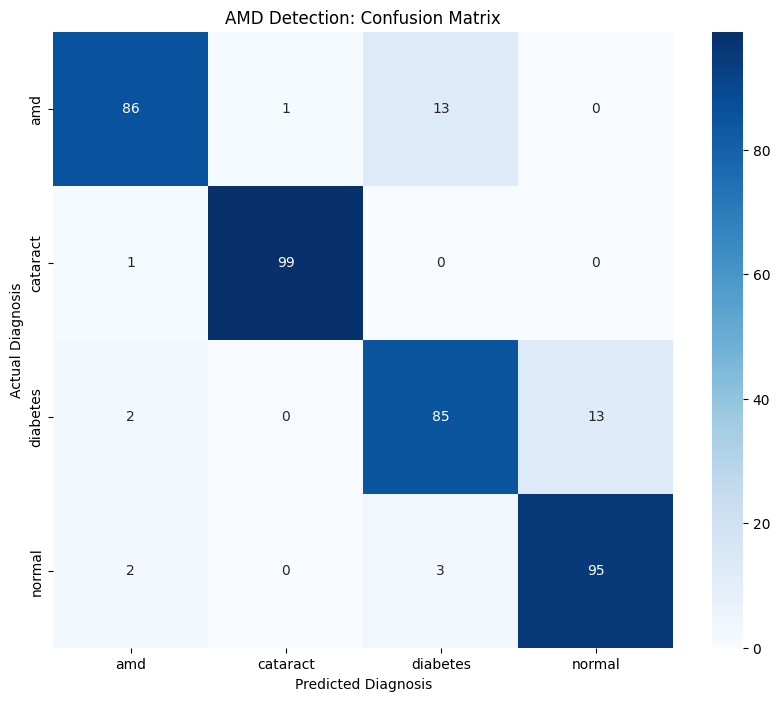

In [ ]:
#Evaluation

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


y_pred = hybrid_model.predict(X_test, batch_size=32)
y_pred_classes = np.argmax(y_pred, axis=1)


print("--- Classification Report ---")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.title('AMD Detection: Confusion Matrix')
plt.ylabel('Actual Diagnosis')
plt.xlabel('Predicted Diagnosis')
plt.show()